# Final Project

![example](./data/Dataset_BUSI_with_GT/benign/benign%20(1).png)

## Testing PyTorch with MNIST Fashion dataset
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [10]:
# Packages
# import tensorflow as tf
# from tensorflow import keras
import torch
from torch import nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

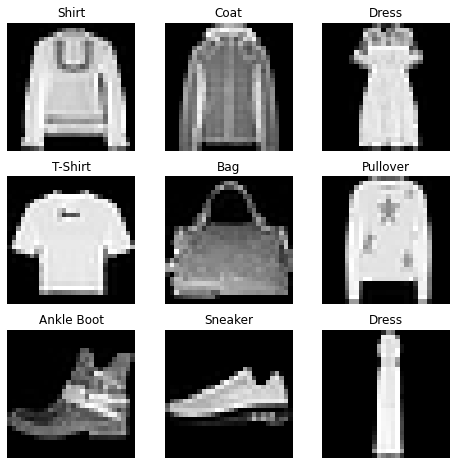

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


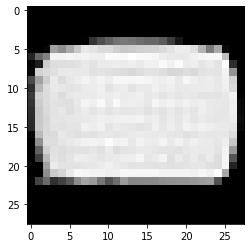

Label: 8


In [4]:
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [14]:
# Ensures use of hardware accelerator, like a gpu
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(f'Using {device} device')

Using cpu device


In [15]:
# Build a Neural Network to classify the MNISTFashion set
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [32]:
# Run the NN
X = torch.rand(1, 28, 28, device=device)
print(X)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred.item()}")

tensor([[[0.9718, 0.2703, 0.4756, 0.7001, 0.0921, 0.8907, 0.1047, 0.0229,
          0.1863, 0.0166, 0.3366, 0.5995, 0.8320, 0.1387, 0.2403, 0.6231,
          0.4519, 0.5152, 0.5610, 0.3600, 0.9576, 0.1416, 0.0498, 0.8859,
          0.4619, 0.3247, 0.3407, 0.4434],
         [0.8018, 0.6140, 0.0948, 0.4440, 0.9818, 0.6290, 0.0410, 0.4709,
          0.4038, 0.2141, 0.5144, 0.8022, 0.2787, 0.6350, 0.6401, 0.6349,
          0.0626, 0.6944, 0.4343, 0.7152, 0.6759, 0.0029, 0.4529, 0.2515,
          0.0599, 0.0285, 0.5152, 0.4333],
         [0.2999, 0.3854, 0.2310, 0.2622, 0.1673, 0.4965, 0.6539, 0.8374,
          0.3174, 0.8431, 0.3881, 0.2537, 0.5672, 0.2161, 0.2353, 0.1084,
          0.6613, 0.2550, 0.4445, 0.8760, 0.5854, 0.8456, 0.5094, 0.0082,
          0.0901, 0.2676, 0.3929, 0.9234],
         [0.0013, 0.4386, 0.6369, 0.3028, 0.2073, 0.1961, 0.1634, 0.6712,
          0.8847, 0.1884, 0.7331, 0.6353, 0.1455, 0.7414, 0.5873, 0.3603,
          0.1742, 0.8097, 0.3350, 0.9117, 0.5787, 0.6918,

## Testing with our tumor data

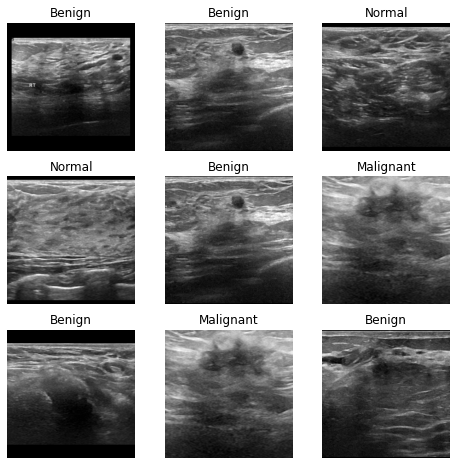

In [6]:
# Following https://medium.com/secure-and-private-ai-writing-challenge/loading-image-using-pytorch-c2e2dcce6ef2
# Get the data
data_dir = './data/Dataset_BUSI_with_GT_no_masks/'  # image directory

    # Here, we can add and extra convolutions/filters/etc of our own to the data
transform = transforms.Compose([transforms.CenterCrop(500), transforms.ToTensor()])  # crop all to same size, transform to tensors
dataset = datasets.ImageFolder(data_dir, transform=transform)  # load images

# Split into testing and training sets
num_samples = len(dataset)
num_test = int(0.1 * num_samples)  # ~10% 
test_set = torch.utils.data.Subset(dataset, range(num_test))  # take first 10%
train_set = torch.utils.data.Subset(dataset, range(num_test, num_samples))  # take the rest 

# Extract images and labels
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)  # Split into batches
images, labels = next(iter(train_dataloader))

# What do the labels mean?
labels_map = {
    0: "Benign",
    1: "Malignant",
    2: "Normal"
}

# Show a few samples
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img = np.transpose(images[sample_idx].numpy(), (1, 2, 0))
    lab = labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[lab])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Feature batch shape: torch.Size([32, 3, 500, 500])
Labels batch shape: torch.Size([32])


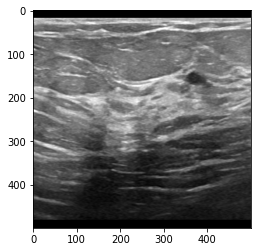

Label: 0 (Benign)


In [7]:
# Show the shape of the features and labels from each batch
# along with a sample from the batch
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = np.transpose(train_features[0].numpy(), (1, 2, 0)).squeeze()
label = train_labels[0].item()
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label} ({labels_map[label]})")